In [51]:
using Random
using CairoMakie
using StatsBase

In [2]:
"""
    An Abelian sandpile model simulation. The sandpile is initialized with a random
    number of grains at each lattice site. Then, a single grain is dropped at a random
    location. The sandpile is then allowed to evolve until it is stable. This process
    is repeated n_step times.

    A single step of the simulation consists of two stages: a random sand grain is 
    dropped onto the lattice at a random location. Then, a set of avalanches occurs
    causing sandgrains to get redistributed to their neighboring locations.
    
    Parameters:
    n::Int: The size of the grid
    rng::MersenneTwister: The random number generator
    grid::Array{Int, 2}: The grid of the sandpile
    history::Array{Array{Int, 2}, 1}: A list of the sandpile grids at each timestep
"""
mutable struct AbelianSandpile
    n::Int
    rng::MersenneTwister
    grid::Array{Int, 2}
    history::Array{Array{Int, 2}, 1}
end

"""
    Initialize and AbelianSandpile with a random grid of grains.

    Parameters:
    n::Int: The size of the grid
    seed::Int: The seed for the random number generator

    Returns:
    AbelianSandpile: The initialized sandpile
"""
function AbelianSandpile(; n::Int=100, seed::Int=0)
    rng = MersenneTwister(seed)
    grid = rand(rng, 0:3, n, n)
    history = [copy(grid)]
    return AbelianSandpile(n, rng, grid, history)
end

"""
    Perform a single step of the Abelian sandpile model. A single grain is dropped
    at a random location on the grid. Then, a set of avalanches occur causing sand
    grains to get redistributed to their neighboring locations.

    Parameters:
    sandpile::AbelianSandpile: The sandpile to perform the step on
"""
function step!(sandpile::AbelianSandpile)
    x,y = rand(sandpile.rng, 1:sandpile.n, 2)
    sandpile.grid[x, y] += 1
    overflow = []

    if sandpile.grid[x,y] >= 4
        push!(overflow, (x,y))
    end

    while !isempty(overflow)
        x, y = pop!(overflow)
        sandpile.grid[x, y] -= 4
        if x > 1
            sandpile.grid[x-1, y] += 1
            if sandpile.grid[x-1, y] >= 4
                push!(overflow, (x-1, y))
            end
        end
        if x < sandpile.n
            sandpile.grid[x+1, y] += 1
            if sandpile.grid[x+1, y] >= 4
                push!(overflow, (x+1, y))
            end
        end
        if y > 1
            sandpile.grid[x, y-1] += 1
            if sandpile.grid[x, y-1] >= 4
                push!(overflow, (x, y-1))
            end
        end
        if y < sandpile.n
            sandpile.grid[x, y+1] += 1
            if sandpile.grid[x, y+1] >= 4
                push!(overflow, (x, y+1))
            end
        end
    end
end

"""
    Check the total number of different sites between two grids.

    Parameters:
    grid1::Array{Int, 2}: The first grid
    grid2::Array{Int, 2}: The second grid

    Returns:
    Int: The number of different elements between the two grids
"""
function check_difference(grid1, grid2)
    return sum(grid1 .!= grid2)
end

"""
    Simulate the Abelian sandpile model for nsteps number of steps. The history of the
    sandpile is stored in the history field of the sandpile.

    Parameters:
    sandpile (AbelianSandpile): The sandpile to simulate
    nsteps (Int): The number of steps to simulate

    Returns:
    Array{Int, 2}: The final grid of the sandpile
"""
function simulate!(sandpile::AbelianSandpile, nsteps::Int)
    for i in 1:nsteps
        step!(sandpile)
        if check_difference(sandpile.history[end], sandpile.grid) > 0
            push!(sandpile.history, copy(sandpile.grid))
        end
    end

    return sandpile.grid
end

simulate! (generic function with 1 method)

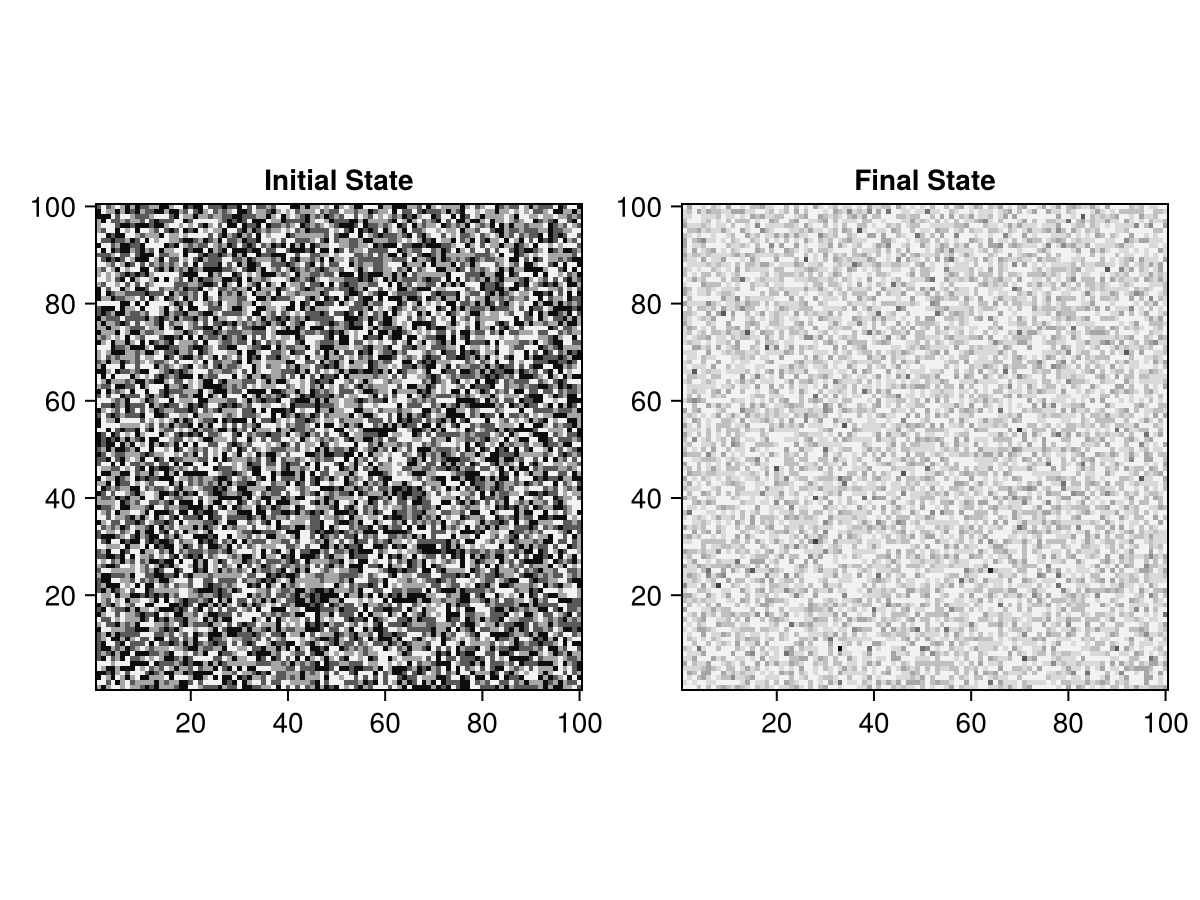

In [109]:
f1 = Figure()
ax = Axis(f1[1, 1])

# Run sandpile simulation
model = AbelianSandpile(n=100, seed=12)

centers_x = 1:100
centers_y = 1:100

heatmap!(ax, centers_x, centers_y, model.grid, colormap=:grays)
ax.aspect = DataAspect()
ax.title = "Initial State"

ax = Axis(f1[1, 2])
simulate!(model, 10_000)
heatmap!(ax, centers_x, centers_y, model.grid, colormap=:grays)
ax.aspect = DataAspect()
ax.title = "Final State"

f1

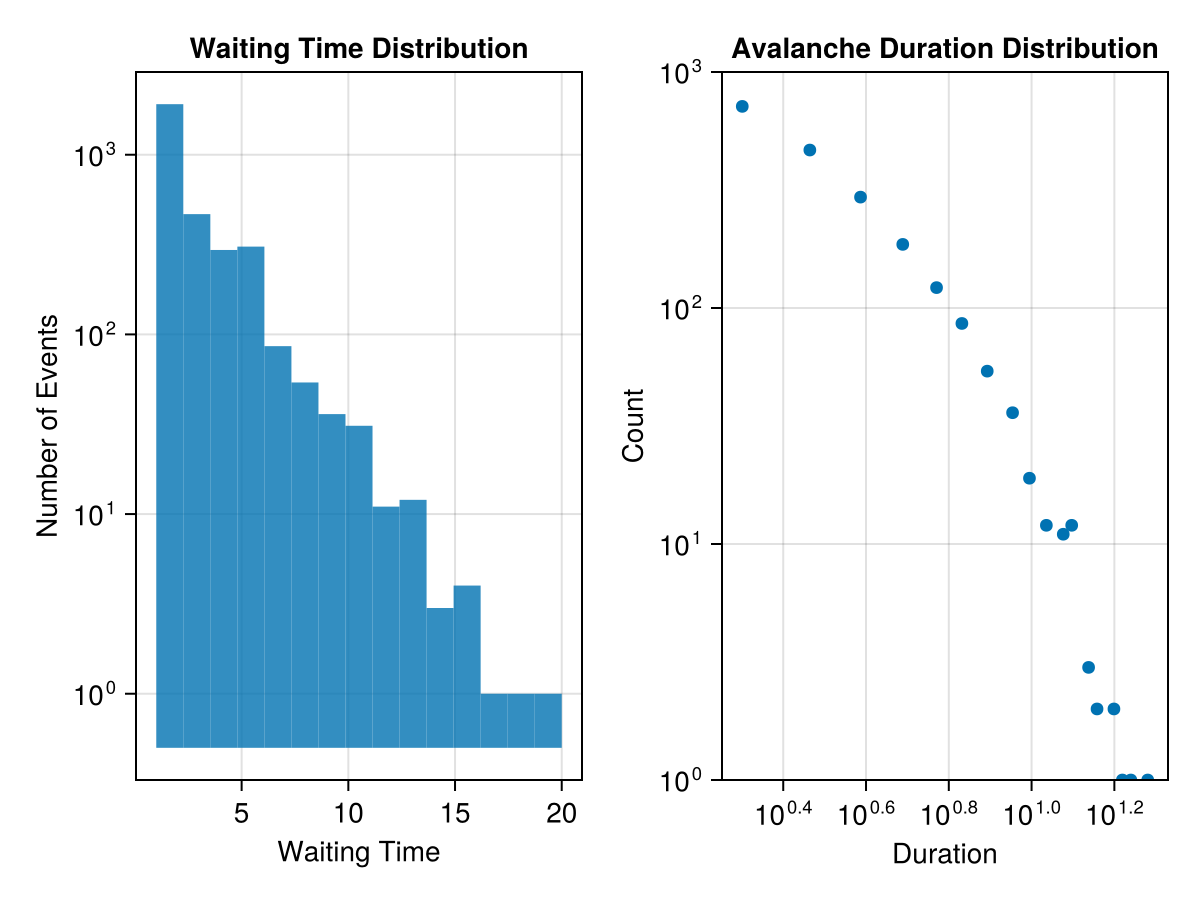

In [73]:
f2 = Figure()

#=
compute the pairwise differences between all snapshots. This command uses list
comprehension, a zip generator, and argument unpacking in order to perform this task
concisely.
=#
all_events = [check_difference(states...) for states in zip(model.history[1:end-1], model.history[2:end])]
# remove transients before the self-organized critical state is reached
all_events = all_events[1000:end]
# index each timestep by timepoint
all_events = collect(enumerate(all_events))
# remove cases where an avalanche did not occur
all_avalanches = [x for x in all_events if x[2] > 1]
all_avalanche_times = [x[1] for x in all_avalanches]
all_avalanche_sizes = [x[2] for x in all_avalanches]
all_avalanche_durations = [event1 - event0 for (event0, event1) in zip(all_avalanche_times[1:end-1], all_avalanche_times[2:end])]

## Waiting time distribution
waiting_times = diff(all_avalanche_times)

ax = Axis(f2[1, 1], yscale=log10)
hist!(ax, waiting_times)
ax.title = "Waiting Time Distribution"
ax.ylabel = "Number of Events"
ax.xlabel = "Waiting Time"

## Duration distribution
ax = Axis(f2[1, 2], yscale=log10, xscale=log10)
logbins = 10 .^ range(log10(2), log10(maximum(all_avalanche_durations)), length=50)
hisfit = fit(Histogram, all_avalanche_durations, logbins)
counts, bins = hisfit.weights, hisfit.edges[1]
scatter!(ax, bins[1:end-1], counts)
ax.title = "Avalanche Duration Distribution"
ax.ylabel = "Count"
ax.xlabel = "Duration"

f2

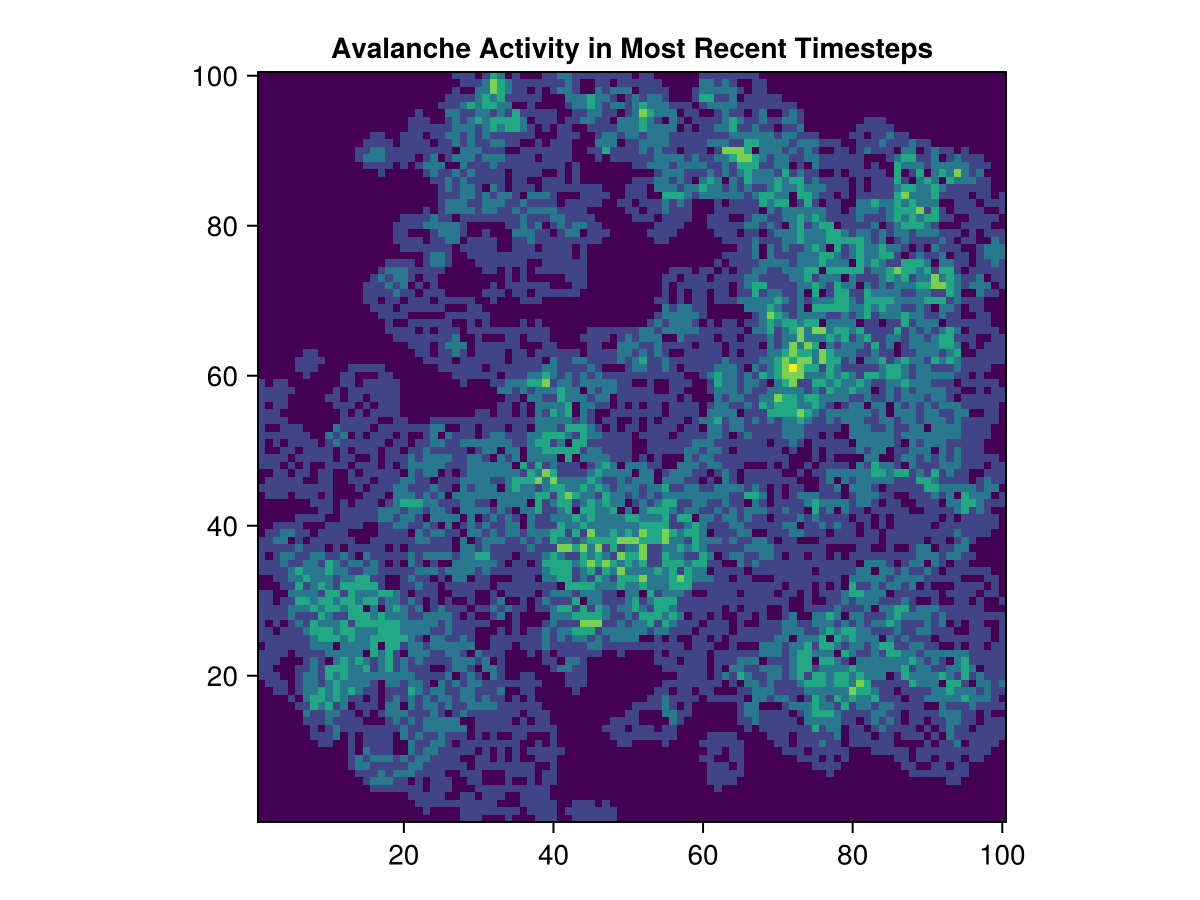

In [112]:
#= 
Visualize activity of the avalanches
Make an array storing all pairwise differences between the lattice at successive
timepoints
=#
all_diffs = cat([clamp.(abs.(states[1] - states[2]), 0, 1) for states in zip(model.history[1:end-1], model.history[2:end])]..., dims=3)
mask = vec(sum(all_diffs, dims=(1, 2)) .> 1) # Filter to only keep big events
all_diffs = all_diffs[:, :, mask]
most_recent_events = sum(all_diffs[:,:,end-100:end], dims=3)[:, :, 1]

f3 = Figure()
ax = Axis(f3[1, 1])
heatmap!(ax, centers_x, centers_y, most_recent_events)
ax.aspect = DataAspect()
ax.title = "Avalanche Activity in Most Recent Timesteps"

f3